## CNN that predicts angle

A simple CNN with one output - a number represents angle of rotation. 

We use this angle to rotate picture back. As a visual indicator of rotation we use drawn rectangles.

In [1]:
import pandas as pd
import numpy as np
from sklearn.utils import shuffle
from sklearn.model_selection import train_test_split
from dataset_helper import DataSet

import tensorflow as tf

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# load train data
rows = pd.read_csv('datalog_train.csv')
angles = rows['angle'].tolist()
samples = rows['image'].tolist()
print("Number of training samples: ", len(angles))

Number of training samples:  11000


In [3]:
# load test data
rows_test = pd.read_csv('datalog_test.csv')
angles_test = rows_test['angle'].tolist()
samples_test = rows_test['image'].tolist()
print("Number of test samples: ", len(samples_test))

Number of test samples:  1000


In [4]:
# split
shuffle(samples, angles)
samples_train, samples_valid, angles_train, angles_valid = train_test_split(samples, angles, test_size=0.3)

In [5]:
data_train = DataSet(angles_train, samples_train)
data_valid = DataSet(angles_valid, samples_valid, 'valid')
# check
print("Number of train samples: ", len(data_train.sample_paths))
print("Number of valid samples: ", len(data_valid.sample_paths))

Number of train samples:  7700
Number of valid samples:  3300


In [6]:
labels = np.unique(data_train.angles)
# labels = np.linspace(-np.max(data_train.angles), np.max(data_train.angles), 60)
print(len(labels))

201


In [7]:
# print((labels + np.max(labels)) * 10)
# labels = (labels + np.max(labels)) * 10

## Network Architecture

In [11]:
# constants
size = 128 # images sape 128x128
epochs = 200
learning_rate = 1e-3

In [8]:
# tensorflow graph placeholders
images_ph = tf.placeholder(tf.float32, (None, size, size, 3), name='images')
angles_ph = tf.placeholder(tf.float32, (None), name='angles')

In [9]:
# cnn architecture
layer1 = tf.layers.conv2d(inputs=images_ph, filters=24, 
                          kernel_size=[3, 3], 
                          strides=(1, 1), 
                          padding='valid',
                          activation=tf.nn.relu)
layer1 = tf.layers.batch_normalization(layer1, training=True)
layer1 = tf.nn.relu(layer1)
layer1 = tf.layers.max_pooling2d(layer1, pool_size=[2, 2], strides=2)
print("layer1: ", layer1.get_shape())

layer2 = tf.layers.conv2d(inputs=layer1, filters=36, 
                          kernel_size=[3, 3], 
                          strides=(1, 1), 
                          padding='valid',
                          activation=tf.nn.relu)
layer2 = tf.layers.batch_normalization(layer2, training=True)
layer2 = tf.nn.relu(layer2)
layer2 = tf.layers.max_pooling2d(layer2, pool_size=[2, 2], strides=2)
print("layer2: ", layer2.get_shape())

layer3 = tf.layers.conv2d(inputs=layer2, filters=48, 
                          kernel_size=[3, 3], 
                          strides=(1, 1), 
                          padding='valid',
                          activation=tf.nn.relu)
layer3 = tf.layers.batch_normalization(layer3, training=True)
layer3 = tf.nn.relu(layer3)
layer3 = tf.layers.max_pooling2d(layer3, pool_size=[2, 2], strides=2)
print("layer3: ", layer3.get_shape())

layer4 = tf.layers.conv2d(inputs=layer3, filters=64, 
                          kernel_size=[3, 3], 
                          strides=(1, 1), 
                          padding='valid',
                          activation=tf.nn.relu)
layer4 = tf.layers.batch_normalization(layer4, training=True)
layer4 = tf.nn.relu(layer4)
layer4 = tf.layers.max_pooling2d(layer4, pool_size=[2, 2], strides=2)
print("layer4: ", layer4.get_shape())

flat = tf.contrib.layers.flatten(layer4)
print("flatten: ", flat.get_shape())

layer5 = tf.layers.dense(inputs=flat, units=1000,
                         activation=tf.nn.relu)
print("layer5: ", layer5.get_shape())

layer6 = tf.layers.dense(inputs=layer5, units=512,
                         activation=tf.nn.relu)
print("layer6: ", layer6.get_shape())

logits = tf.layers.dense(inputs=flat, units=len(labels))
print("logits: ", logits.get_shape())

layer1:  (?, 63, 63, 24)
layer2:  (?, 30, 30, 36)
layer3:  (?, 14, 14, 48)
layer4:  (?, 6, 6, 64)
flatten:  (?, 2304)
layer5:  (?, 1000)
layer6:  (?, 512)
logits:  (?, 201)


In [10]:
# training pipeline
# prediction = tf.reduce_sum((tf.sigmoid(logits) / tf.reduce_sum(logits)) * labels, 1)
probabilities = tf.nn.softmax(logits, 1)
prediction = tf.reduce_sum(probabilities * labels, 1)# / 10 - np.max(labels)
loss = tf.reduce_mean(tf.squared_difference(prediction, angles_ph))
# loss = tf.reduce_mean(tf.abs(prediction - angles_ph))
optimizer = tf.train.AdamOptimizer(learning_rate=learning_rate)
# training_operation = optimizer.minimize(loss)

update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
with tf.control_dependencies(update_ops):
    training_operation = optimizer.minimize(loss)

saver = tf.train.Saver()

In [12]:
%%time
# train model
with tf.Session() as sess:
    sess.run(tf.global_variables_initializer())
    
    loss_plot = []

    print("Training...")
    print()
    print("learning rate: ", learning_rate)
    
    for epoch in range(epochs):
        if (epoch + 1) != epochs and (epoch + 1) % 50 == 0:
            learning_rate *= 0.3
            print("New learning rate: ", learning_rate)
            print()
        
        # training
        batch_imgs, batch_lbls = data_train.get_next_batch()
        _, training_loss, pred = sess.run([training_operation, loss, prediction], 
                                          feed_dict={images_ph: batch_imgs,
                                                     angles_ph: batch_lbls})
        
        # validation
        valid_batch_imgs, valid_batch_lbls = data_valid.get_next_batch()           
        validation_loss = sess.run(loss, feed_dict={images_ph: valid_batch_imgs,
                                                    angles_ph: valid_batch_lbls})

        loss_plot.append((training_loss, validation_loss))
        
#         def print_values(title, values):
#             s = "".join(["%+7.2f" % v for v in values])
#             print(title + "[%s]" % s)    
#         print_values("True: ", batch_lbls[:12])
#         print_values("Pred: ", pred[:12])
        
        if epoch % 25 == 0:
            print("EPOCH {} ...".format(epoch + 1))
            print("Train loss =", training_loss, ", Valid loss =", validation_loss)    
    
    plot_loss = pd.DataFrame(loss_plot, columns=['train_loss', 'valid_loss'])
        
    saver.save(sess, './tf_model/dev10/model_tf')
    print("Model saved")

Training...

learning rate:  0.001
EPOCH 1 ...
Train loss = 37.7273 , Valid loss = 33.5227
EPOCH 26 ...
Train loss = 6.20712 , Valid loss = 8.95554
New learning rate:  0.0003

EPOCH 51 ...
Train loss = 3.57318 , Valid loss = 3.3327
EPOCH 76 ...
Train loss = 2.49309 , Valid loss = 3.99155
New learning rate:  8.999999999999999e-05

EPOCH 101 ...
Train loss = 2.13747 , Valid loss = 2.37086
EPOCH 126 ...
Train loss = 1.70377 , Valid loss = 2.09178
New learning rate:  2.6999999999999996e-05

EPOCH 151 ...
Train loss = 2.32657 , Valid loss = 1.39715
EPOCH 176 ...
Train loss = 1.34611 , Valid loss = 0.875523
Model saved
CPU times: user 49.7 s, sys: 7.65 s, total: 57.4 s
Wall time: 1min 16s


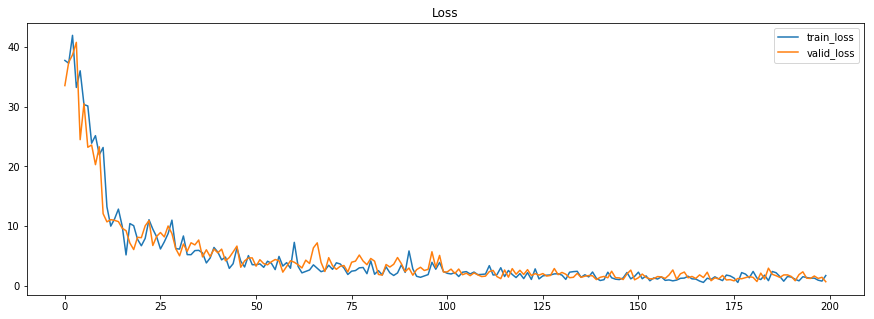

In [13]:
# plot loss
# fig, (ax, ax2) = plt.subplots(ncols=2)
# plot_acc.plot(title='Accuracy', figsize=(15, 5), ax=ax)
plot_loss.plot(title='Loss', figsize=(15, 5))
plt.show()

## Evaluate model

In [14]:
batch_size = 100
data_test  = DataSet(angles_test, samples_test, 'test', batch_size=batch_size)
print("Number of test samples:  ", len(data_test.sample_paths))

Number of test samples:   1000


INFO:tensorflow:Restoring parameters from ./tf_model/dev10/model_tf
100
True: [  +0.70  -1.00  +1.90  +0.90  +4.10  +7.50  -3.70  -9.20  +0.80  -8.90  -2.20  -7.80]
Pred: [  +2.19  +0.16  +1.66  +2.09  +4.67  +6.57  -4.36  -8.47  +2.07  -8.39  -1.98  -7.41]
Diff: [  -1.49  -1.16  +0.24  -1.19  -0.57  +0.93  +0.66  -0.73  -1.27  -0.51  -0.22  -0.39]
Mean diff: 0.76


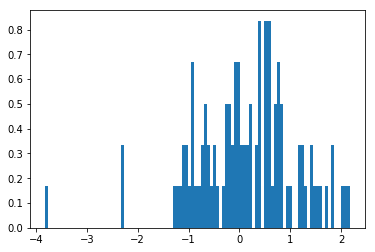

In [16]:
# evaluate model
with tf.Session() as sess:
    loader = tf.train.import_meta_graph('./tf_model/dev10/model_tf.meta')
    loader.restore(sess, tf.train.latest_checkpoint('./tf_model/dev10'))
    
    test_batch_imgs, test_batch_lbls = data_test.get_next_batch()
    print(len(test_batch_imgs))
    
    predictions = sess.run(prediction, feed_dict={images_ph: test_batch_imgs, 
                                                  angles_ph: test_batch_lbls})
    # print(predictions)
    def print_values(title, values):
        s = "".join(["%+7.2f" % v for v in values])
        print(title + "[%s]" % s)    
    print_values("True: ", test_batch_lbls[:12])
    print_values("Pred: ", predictions[:12])
    print_values("Diff: ", test_batch_lbls[:12]-predictions[:12])
    print("Mean diff: %.2f" % np.mean(np.abs(test_batch_lbls-predictions)))
    plt.hist(predictions-test_batch_lbls, bins=100, normed=True)
    plt.show()
    

In [13]:
random.seed(7)
idx = []
t_a = []
t_i = []
for i in range(30):
    index = random.randint(0, len(angles_test)-1)
    angle = angles_test[index]
    img = mpimg.imread(samples_test[index])
    img = resize(img)
    img = normalize(img)
    
    idx.append(index)
    t_a.append((angle + np.max(labels)) * 10)
    t_i.append(img)
    

with tf.Session() as sess:
    loader = tf.train.import_meta_graph('./tf_model/dev/model_tf.meta')
    loader.restore(sess, tf.train.latest_checkpoint('./tf_model/dev'))
    predicted_label = tf.argmax(logits, 1)
    predictions = sess.run(predicted_label, feed_dict={x: t_i, mode: False})

for i in range(30):
    print("Image {}: predicted angle = {:.1f}, actual angle = {:.1f}".format(idx[i], 
                                                                    (predictions[i] / 10 - np.max(labels)),
                                                                    (t_a[i] / 10 - np.max(labels))))

INFO:tensorflow:Restoring parameters from ./tf_model/dev/model_tf
Image 331: predicted angle = 0.0, actual angle = -3.8
Image 970: predicted angle = 2.0, actual angle = -2.6
Image 154: predicted angle = -5.0, actual angle = -9.5
Image 404: predicted angle = -6.9, actual angle = -9.9
Image 666: predicted angle = -6.0, actual angle = -9.1
Image 49: predicted angle = -6.8, actual angle = -9.8
Image 74: predicted angle = 1.1, actual angle = -3.1
Image 840: predicted angle = 2.0, actual angle = -9.2
Image 548: predicted angle = 8.5, actual angle = 7.5
Image 96: predicted angle = 6.8, actual angle = 7.6
Image 374: predicted angle = 0.4, actual angle = 0.9
Image 596: predicted angle = 3.5, actual angle = 0.8
Image 59: predicted angle = 3.4, actual angle = 4.6
Image 931: predicted angle = -7.9, actual angle = -7.4
Image 519: predicted angle = 2.6, actual angle = 4.3
Image 219: predicted angle = 8.3, actual angle = 8.6
Image 38: predicted angle = 0.6, actual angle = -8.0
Image 88: predicted ang

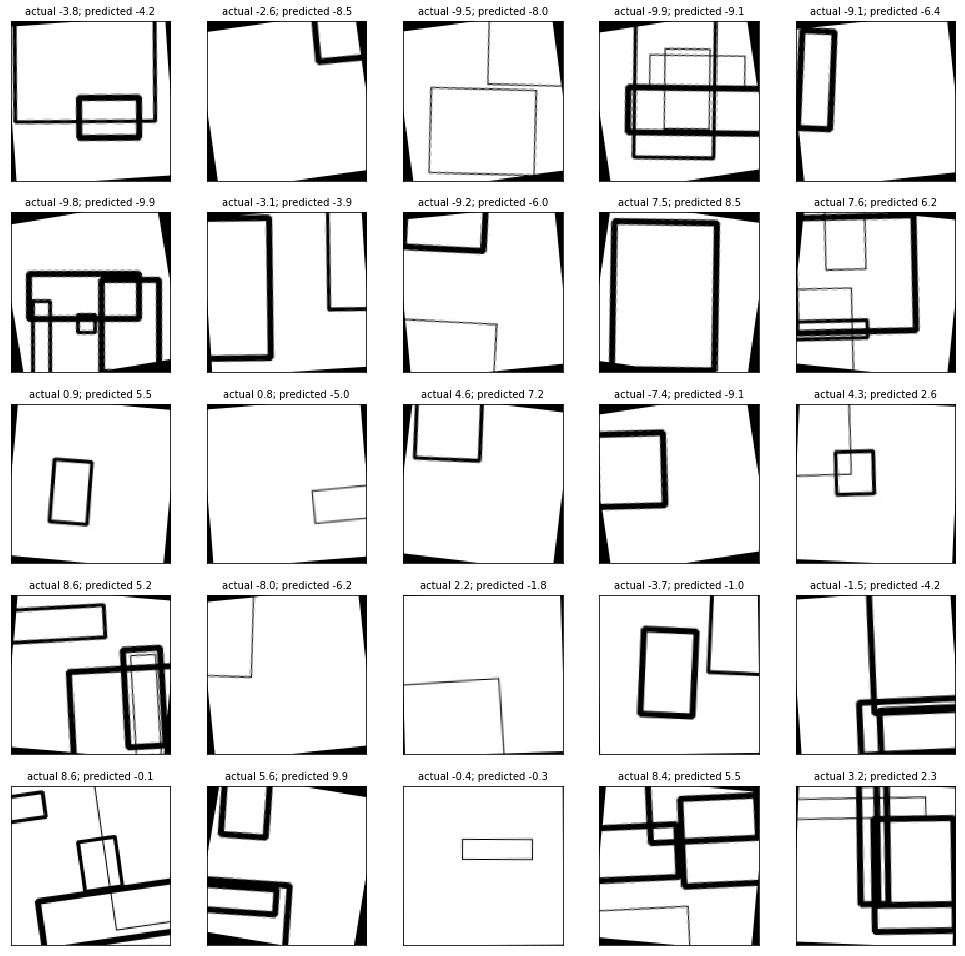

In [18]:
# angle correction
def rotate(img, ang):
    height, width, ch = img.shape
    sh = (width, height)
    center = (width // 2, height // 2)
    M = cv2.getRotationMatrix2D(center, ang, 1.0)
    return cv2.warpAffine(img, M, sh)

n_rows = 5
n_cols = 5
plt.figure(figsize=(17, 17))

# print corrected images
for i in range(n_rows*n_cols):
    plt.subplot(n_rows, n_cols, i+1)
    image = mpimg.imread(samples_test[idx[i]])
    angle = angles_test[idx[i]]
    predicted_angle = predictions[i] / 10 - np.max(labels)
    # correct rotation
    image = rotate(image, -predicted_angle)
    # plot image
    plt.title('actual {}; predicted {}'.format(angle, round(predicted_angle,1)), fontsize=10)
    plt.tick_params(bottom='off', left='off', labelbottom='off', labelleft='off')
    plt.imshow(image)

64 64


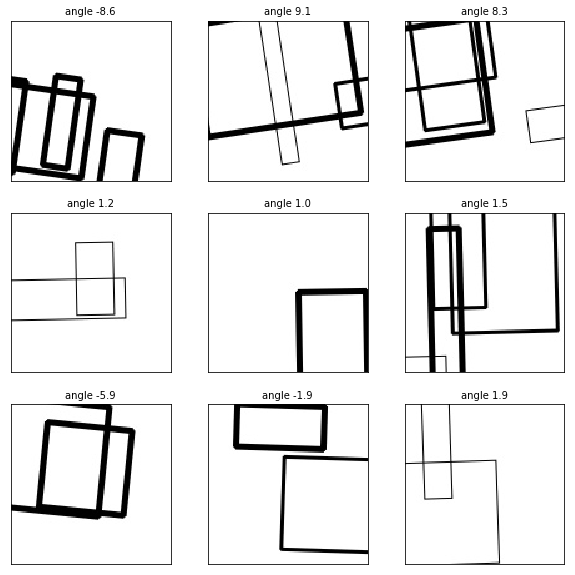

In [6]:
bi, ba = data_train.get_next_batch()
print(len(bi), len(ba))
n_rows = 3
n_cols = 3
plt.figure(figsize=(10, 10))
for i in range(n_rows*n_cols):
    plt.subplot(n_rows, n_cols, i+1)
    image = bi[i]
    angle = ba[i]
    plt.title('angle {}'.format(angle), fontsize=10)
    plt.tick_params(bottom='off', left='off', labelbottom='off', labelleft='off')
    plt.imshow(image)

In [13]:
print(bi[0].shape)

(128, 128, 3)
